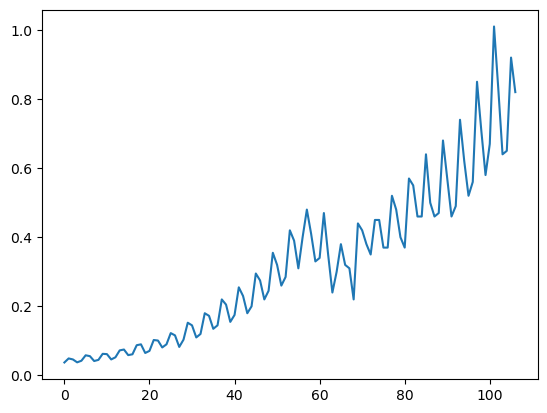

Longitud 107


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('coca_cola_earnings.csv', sep=";",decimal=",")
y = data.iloc[:,1]

plt.plot(y)
plt.show()
print("Longitude", len(y))

In [13]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

adf_test = sm.tsa.stattools.adfuller(y,maxlag=20) 

print("ADF test for the original series")
print("Statistic Value:" , adf_test[0]) # indexing the test statistic
print("p-value:" , adf_test[1]) # indexing the p-value


# Formal Tests
s = 4
d = ndiffs(y, alpha = 0.05, test='adf') 
D = nsdiffs(y, m = s, test='ocsb') # OCSB test is used for seasonal differences

print("Regular differences: ", d)
print('Seasonal differences:', D)

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

ADF test for the original series
Statistic Value: 1.3490910100974873
p-value: 0.9968701406695681
Regular differences:  1
Seasonal differences: 1


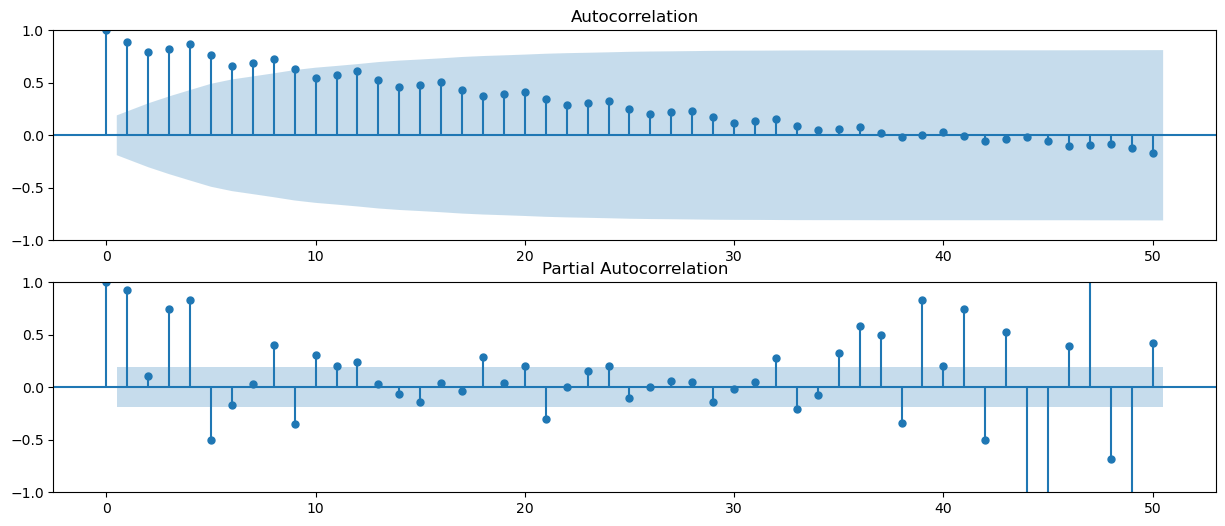

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 50 # we can play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  107
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 4)   Log Likelihood                 172.769
Date:                           Mon, 11 Nov 2024   AIC                           -337.538
Time:                                   15:08:24   BIC                           -327.077
Sample:                                        0   HQIC                          -333.303
                                           - 107                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7838      0.062    -12.700      0.000      -0.905      -0.663
ar.L2         -0.4705      0.077     -6.075

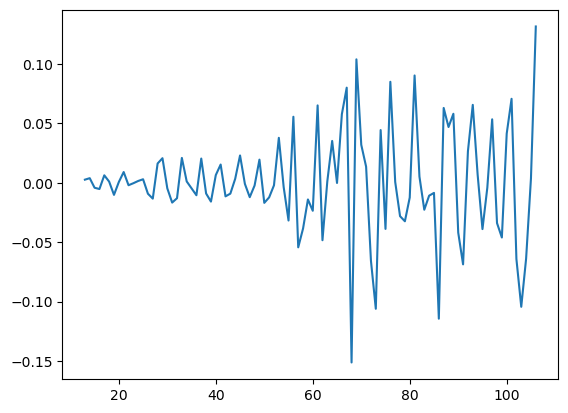

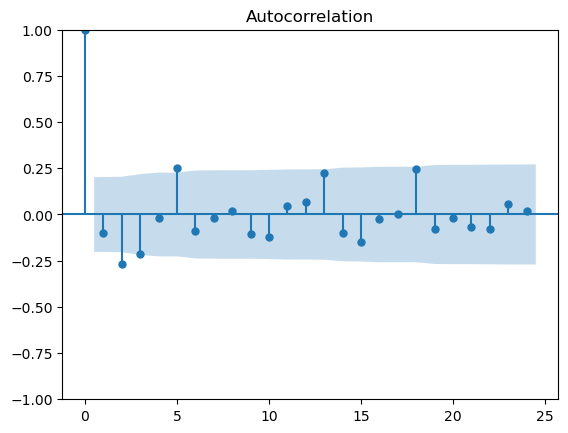

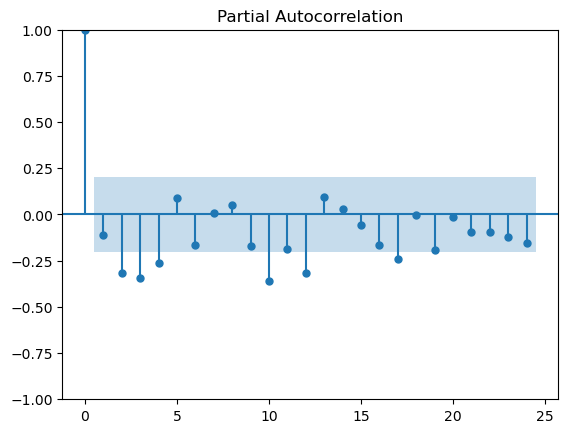

In [41]:
s = 4

fit = SARIMAX(endog=y, order=(2,2,0), seasonal_order=(1,1,0,4)).fit(disp=False)
print(fit.summary())
residuals = fit.resid[13:]

nlags=24

plt.plot(residuals) # plotting the time series
plt.show()
plot_acf(residuals, lags = nlags) # plotting the ACF
plt.show()
plot_pacf(residuals, method="ols",lags = nlags) # plotting the PACF
plt.show()

In [42]:
d = ndiffs(residuals, alpha = 0.05, test='adf')  # any more regular differences?
D = nsdiffs(residuals, m = s, test='ocsb') # any more seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  0
Seasonal differences: 0


The first time performing the test above, it asked for 1 more difference, therefore we changed the SARIMAX model 'd' parameter to 2 instead of 1

In [48]:
import statsmodels.api as sm

# Run the Ljung-Box test
box_test = sm.stats.acorr_ljungbox(residuals, lags=[50], return_df=True)

# Print the results
print("Ljung-Box Statistic value:", box_test['lb_stat'].values[0])
print("p-value:", box_test['lb_pvalue'].values[0])

# Ho: the residuals are not autocorrelated
# H1: the residuals are autocorrelated

Ljung-Box Statistic value: 60.506234072990644
p-value: 0.1467315260389012


Shapido: Statistic value 0.9545419216156006 p-value 0.002475800458341837


/var/folders/hf/w0w6tjn94vn23bsnk58tsp6m0000gn/T/ipykernel_61914/7005343.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(residuals, hist = False, kde = True,
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


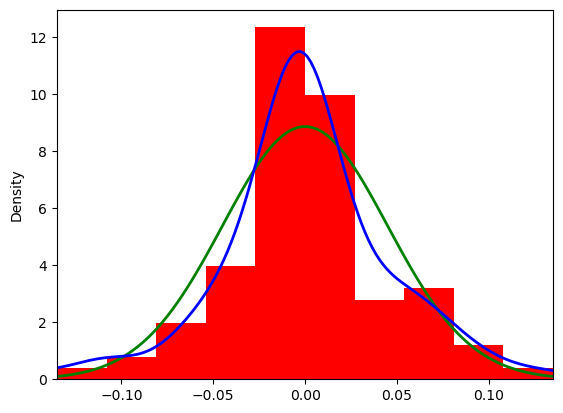

In [49]:
from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normality residuals test

saphiro = shapiro(residuals)
print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # indexing the test statistic and the p-value

mean = np.mean(residuals)
std = np.std(residuals)
mu = np.mean(residuals)
sigma = np.std(residuals)
x = np.linspace(mu -3*sigma, mu +3*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuals,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(residuals, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 3*std, mean + 3*std)

plt.show()

# Ho: the residuals are normally distributed
# H1: the residuals are not normally distributed

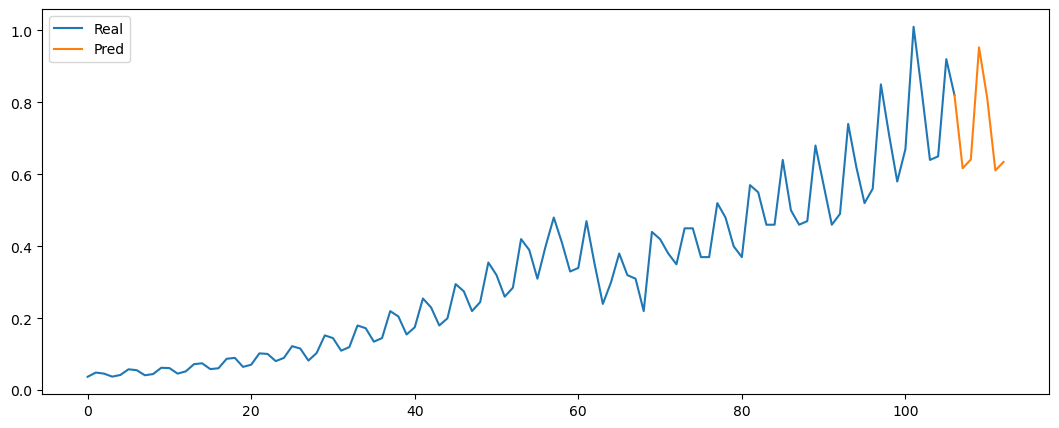

In [52]:
# Forecasting with SARIMA model the next 24 months or 6 quarters 
y_pred = fit.forecast(steps = 6)

# Adding the last real value to the predictions
y_pred.loc[len(y)-1] = y[len(y)-1]

# Sorting the predictions
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Plotting the real and predicted values
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()